In [1]:
from google.colab import files
uploaded = files.upload()

Saving trainingData.zip to trainingData.zip


In [2]:
import zipfile
import os

# Unzipping the uploaded file
zip_path = 'trainingData.zip'  # Replace with your file name
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/trainingData')

data_dir = '/content/trainingData/trainingData'  # Path to extracted folder


Class counts: {'K': 30, 'H': 48, 'G': 68, 'M': 41}


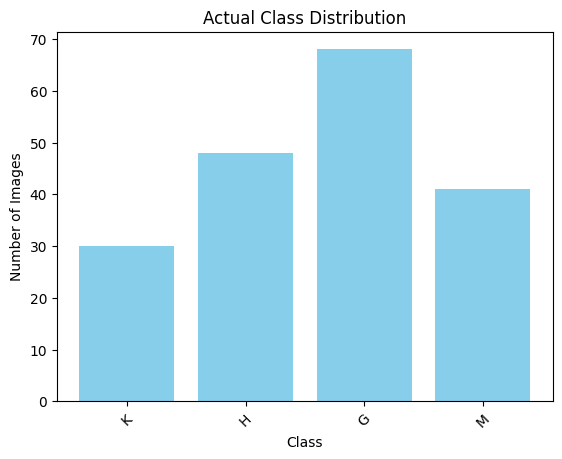

In [3]:
import matplotlib.pyplot as plt

# Function to calculate class sizes
def calculate_class_sizes(directory):
    class_sizes = {
        class_name: len([
            f for f in os.listdir(os.path.join(directory, class_name))
            if not f.startswith('.')
        ])
        for class_name in os.listdir(directory) if os.path.isdir(os.path.join(directory, class_name))
    }
    return class_sizes

class_counts = calculate_class_sizes(data_dir)

# Display the actual counts
print("Class counts:", class_counts)

# Generate a bar chart for the actual class counts
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Actual Class Distribution")
plt.xticks(rotation=45)
plt.show()



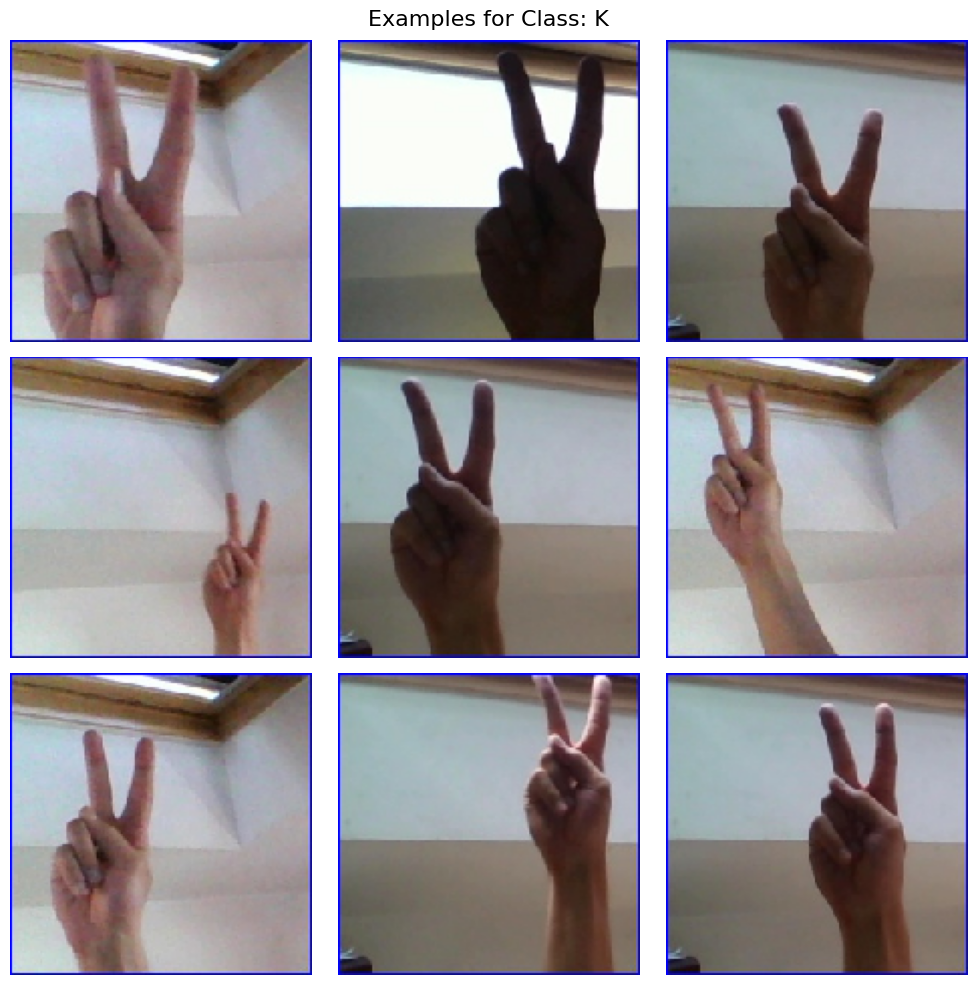

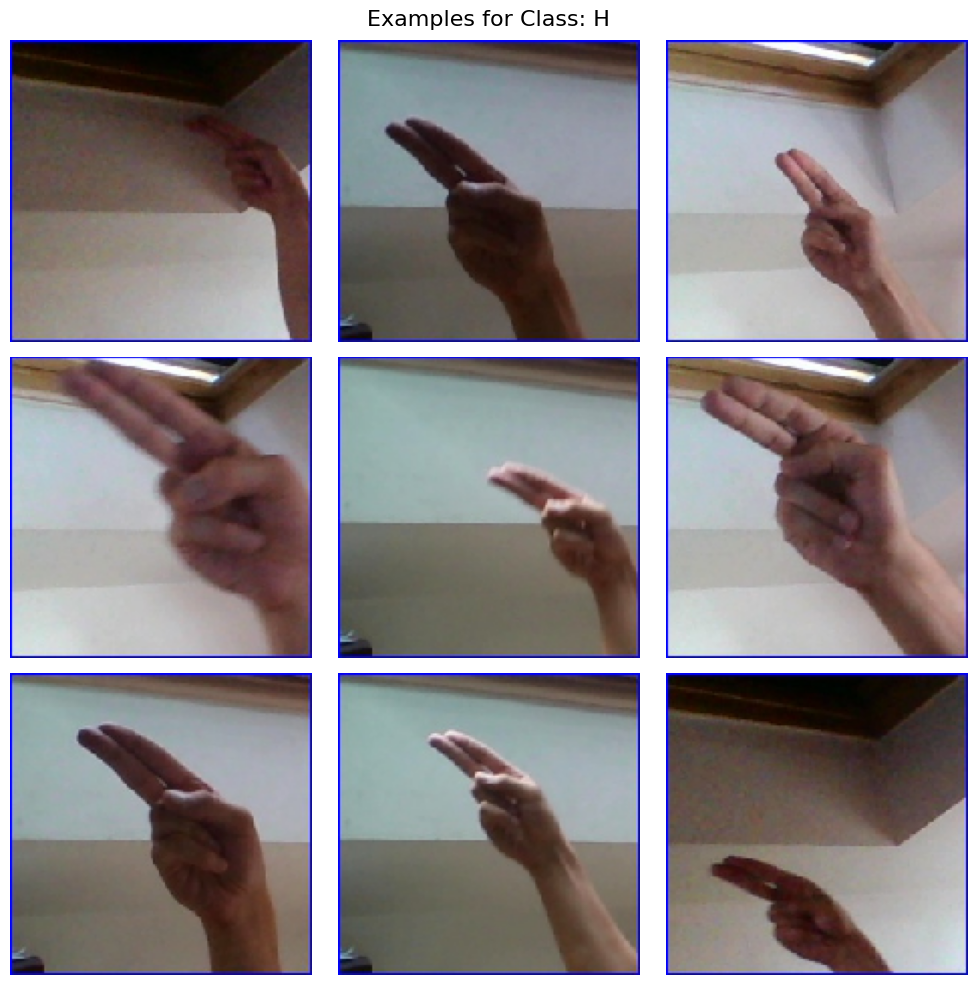

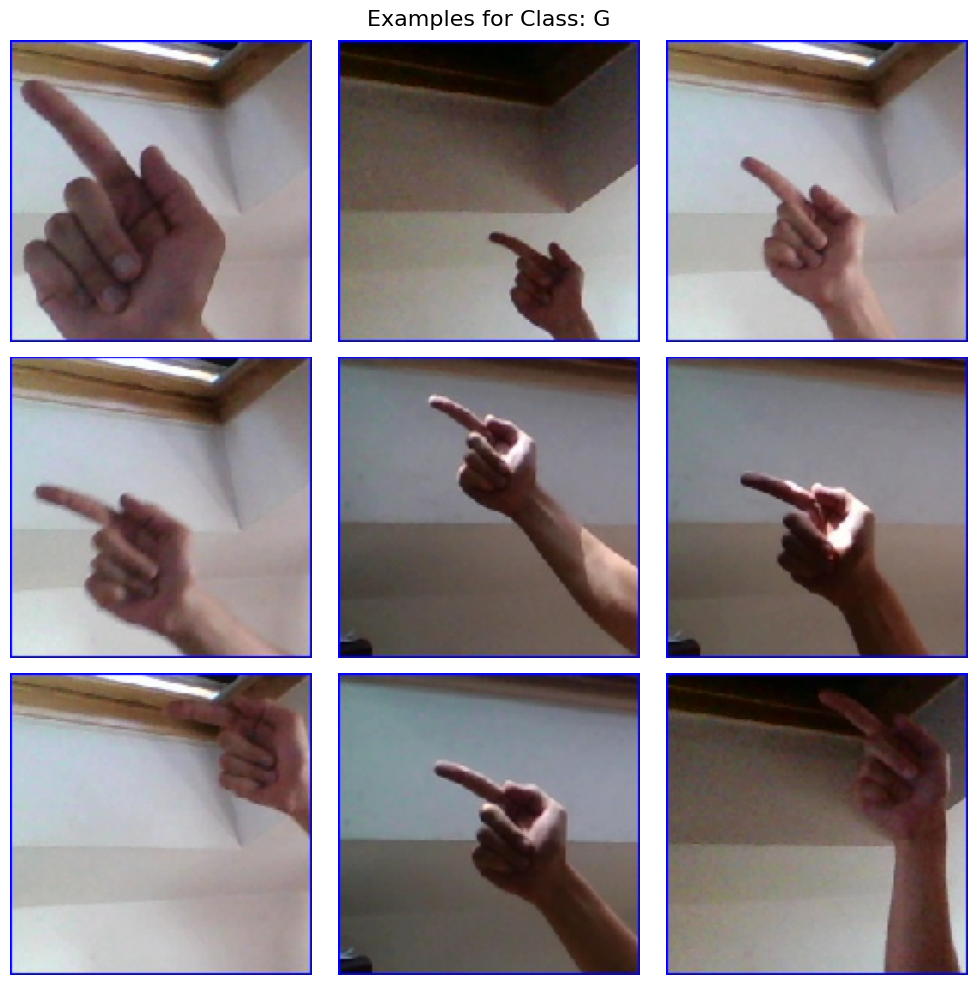

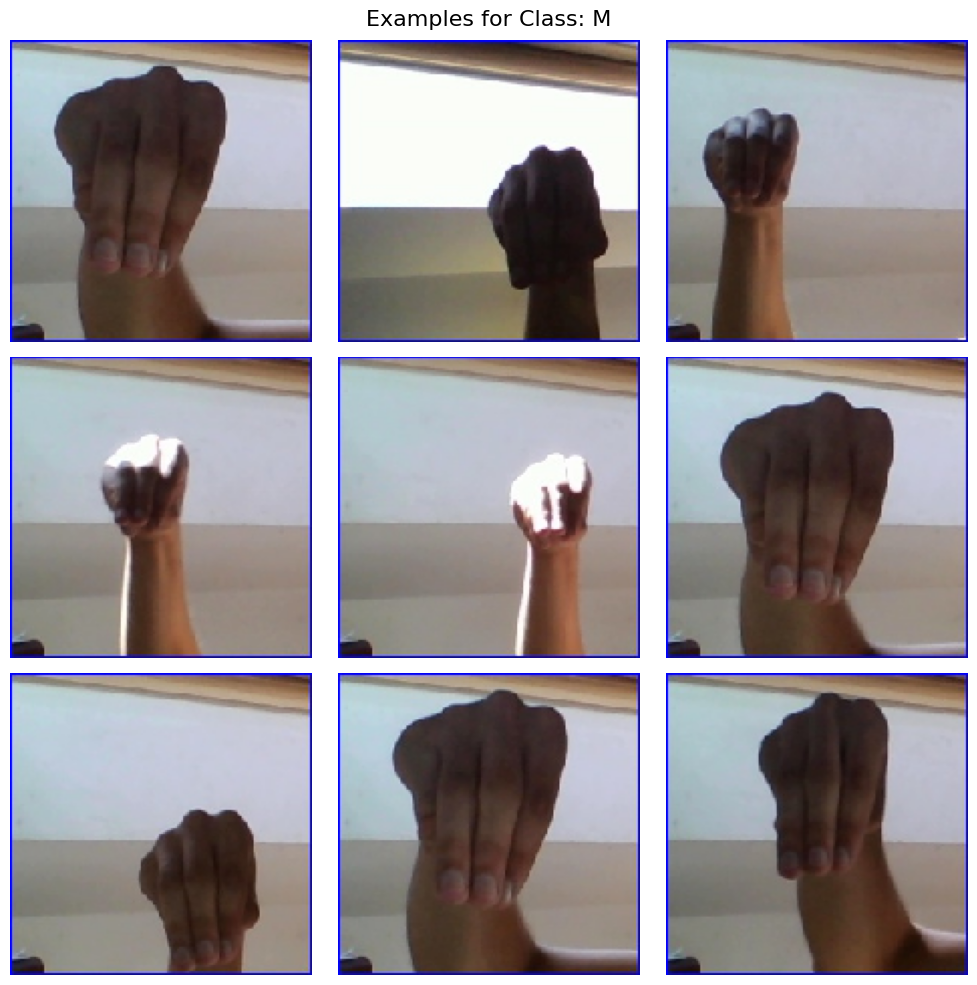

In [4]:
import random
from tensorflow.keras.preprocessing.image import load_img

# Function to create a 3x3 collage for a specific class
def create_collage_from_folder(data_dir, label):
    # Path to the specific class folder
    folder_path = os.path.join(data_dir, label)

    # Get all file paths in the folder, ignoring hidden files like .DS_Store
    filepaths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if not file.startswith('.')]

    # Select 9 random images for the collage
    selected_images = random.sample(filepaths, 9)

    # Create a 3x3 plot grid for the images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(f"Examples for Class: {label}", fontsize=16)

    for i, ax in enumerate(axes.flat):
        img = load_img(selected_images[i], target_size=(150, 150))  # Load image and resize
        ax.imshow(img)
        ax.axis('off')  # Hide axis
    plt.tight_layout()
    plt.show()

# Get the list of classes (subfolders in the data_dir)
classes = [folder for folder in os.listdir(data_dir) if not folder.startswith('.')]

# Create collages for each class
for label in classes:
    create_collage_from_folder(data_dir, label)


In [5]:
import shutil
from sklearn.model_selection import train_test_split

validation_dir = "/content/validationData"
training_dir = "/content/CalibrationData"

# Create directories for validation and training
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(training_dir, exist_ok=True)

# Split data for each class
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Get all image paths for the class
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if not f.startswith('.')]

    # Split into training and validation (20 samples for validation)
    train_images, val_images = train_test_split(images, test_size=20, random_state=42)

    # Move validation images to the validation directory
    val_class_dir = os.path.join(validation_dir, class_name)
    os.makedirs(val_class_dir, exist_ok=True)
    for img in val_images:
        shutil.copy(img, os.path.join(val_class_dir, os.path.basename(img)))

    # Move remaining images to the training directory
    train_class_dir = os.path.join(training_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    for img in train_images:
        shutil.copy(img, os.path.join(train_class_dir, os.path.basename(img)))

print("Split complete. Validation set in:", validation_dir)
print("Remaining training data in:", training_dir)

# Calculate and print validation and training class sizes
training_sizes = calculate_class_sizes(training_dir)
print("Training Class Sizes:", training_sizes)
validation_sizes = calculate_class_sizes(validation_dir)
print("Validation Class Sizes:", validation_sizes)

Split complete. Validation set in: /content/validationData
Remaining training data in: /content/CalibrationData
Training Class Sizes: {'K': 10, 'H': 28, 'G': 48, 'M': 21}
Validation Class Sizes: {'K': 20, 'H': 20, 'G': 20, 'M': 20}


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation settings
datagen = ImageDataGenerator(
    rescale=1.0/255.0,        # Normalize pixel values
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
)



In [7]:
target_samples = 100


# Balance the classes in the training directory
for class_name in os.listdir(training_dir):
    class_path = os.path.join(training_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Count current number of images
    current_count = len([f for f in os.listdir(class_path) if not f.startswith('.')])
    print(f"Class '{class_name}' has {current_count} samples.")

    # If the class already has 100 samples, skip augmentation
    if current_count >= target_samples:
        continue

    # Generate augmented images
    temp_generator = datagen.flow_from_directory(
        directory=training_dir,
        classes=[class_name],
        target_size=(224, 224),
        batch_size=1,
        save_to_dir=class_path,
        save_prefix=class_name,
        save_format='jpg'
    )

    # Generate enough images to reach the target_samples
    for _ in range(target_samples - current_count):
        next(temp_generator)


training_sizes = calculate_class_sizes(training_dir)
print("Training Class Sizes:", training_sizes)

Class 'K' has 10 samples.
Found 10 images belonging to 1 classes.
Class 'H' has 28 samples.
Found 28 images belonging to 1 classes.
Class 'G' has 48 samples.
Found 48 images belonging to 1 classes.
Class 'M' has 21 samples.
Found 21 images belonging to 1 classes.
Training Class Sizes: {'K': 100, 'H': 100, 'G': 100, 'M': 100}


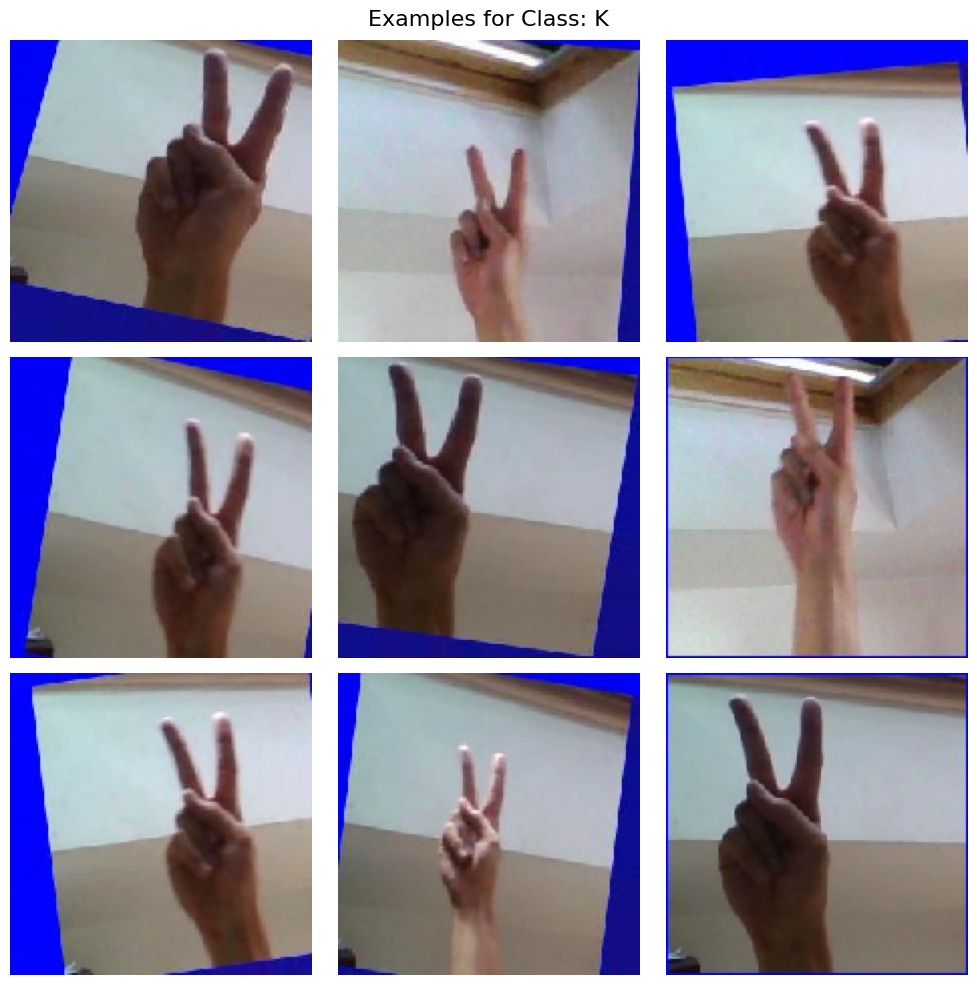

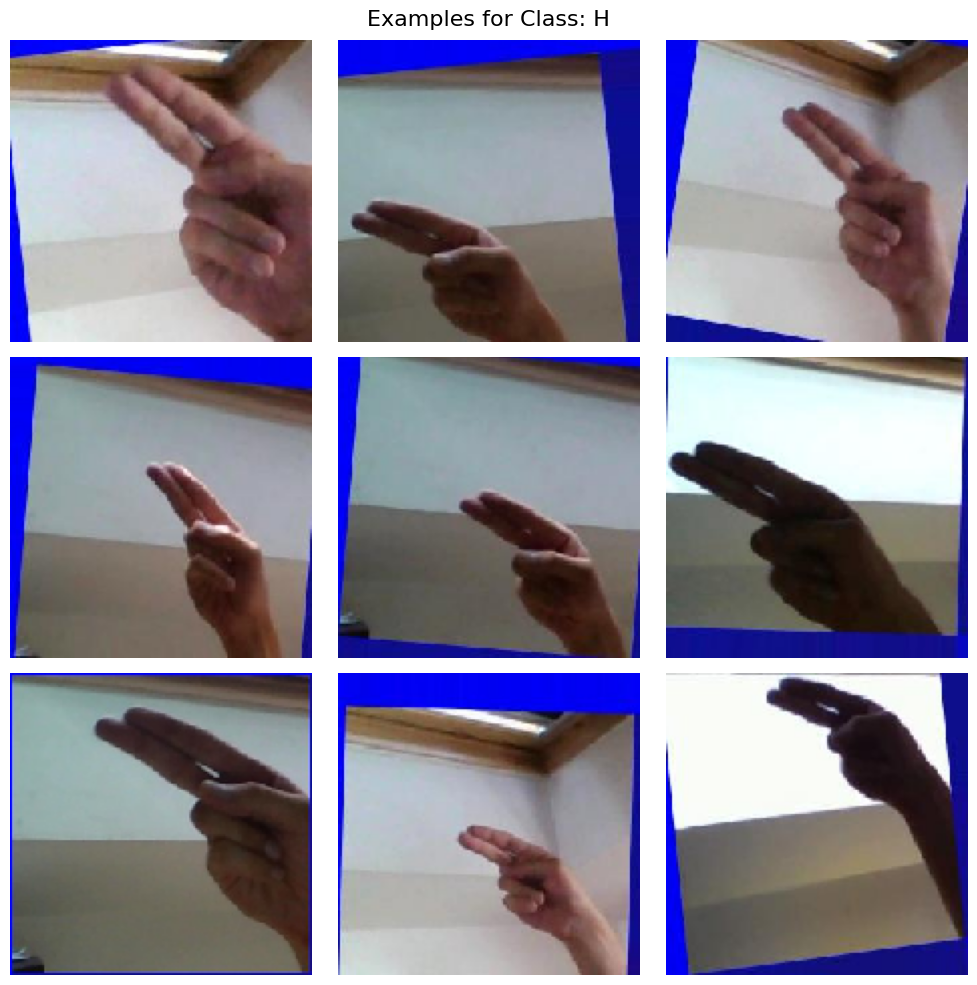

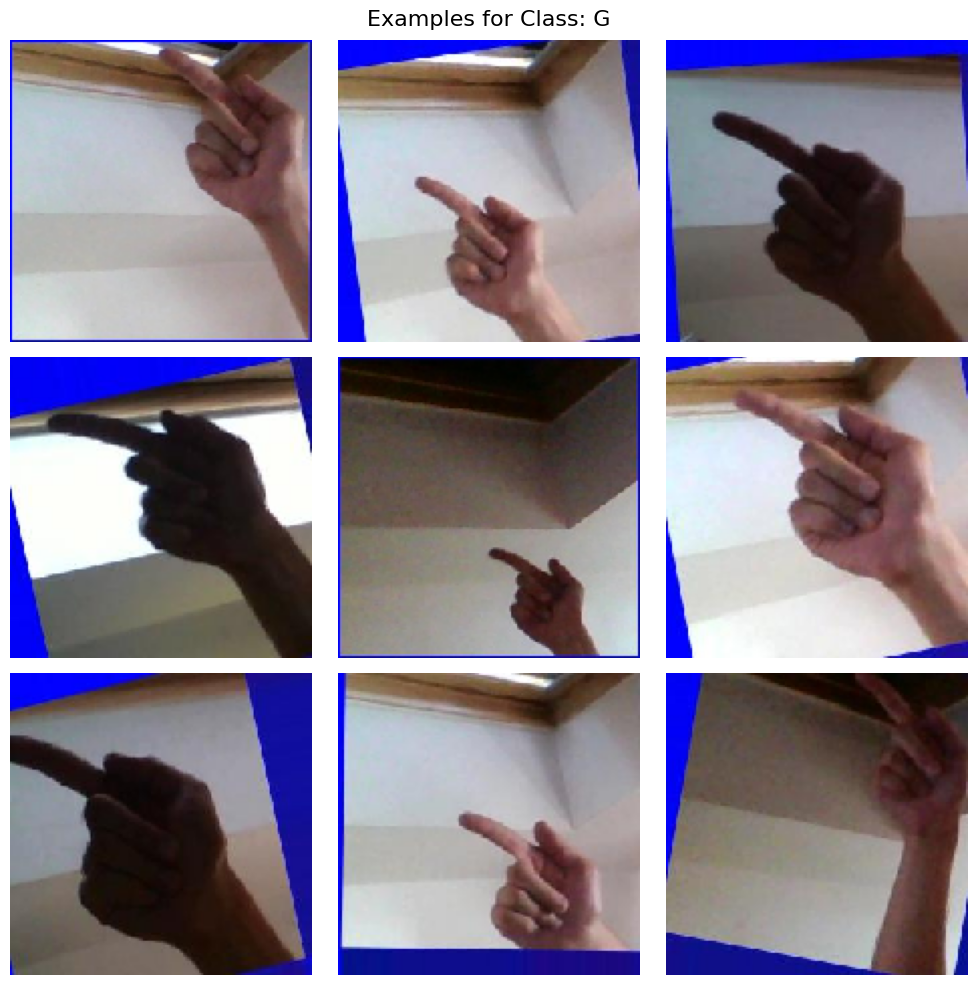

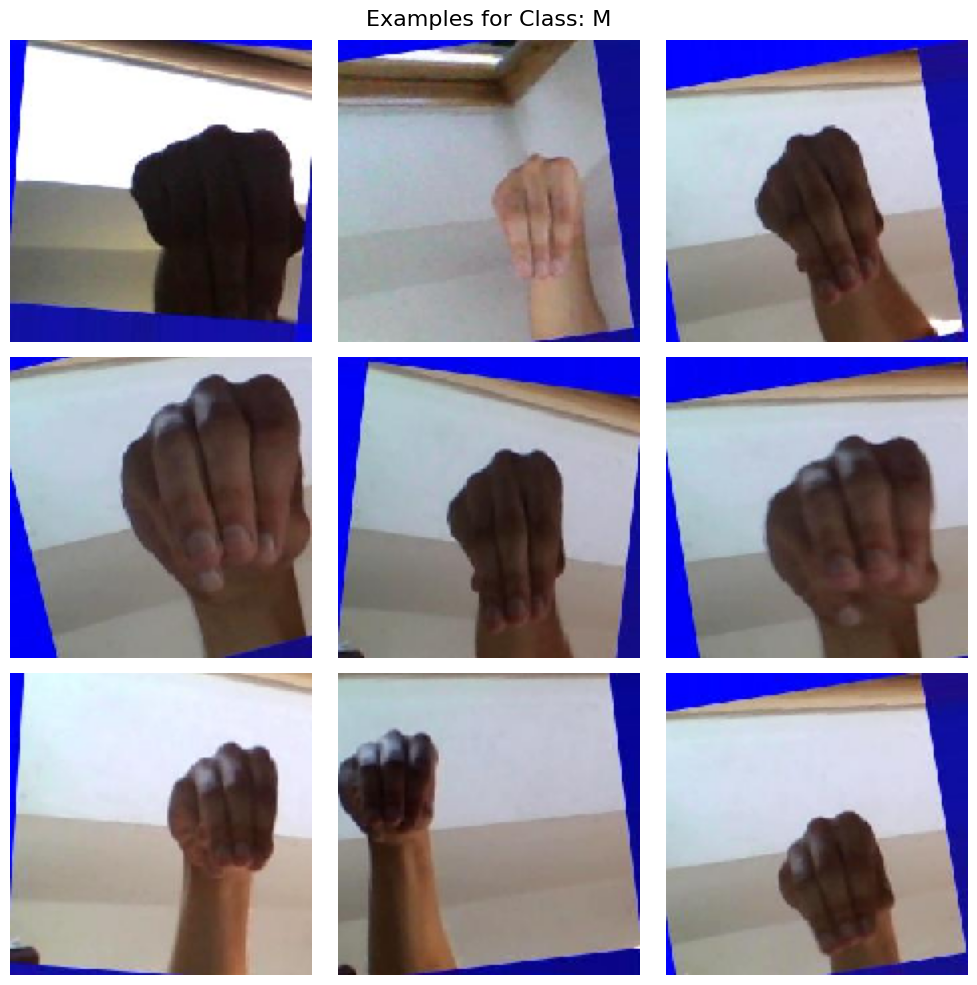

In [8]:
for label in classes:
    create_collage_from_folder(training_dir, label)

In [9]:
# No augmentation for validation data
validation_datagen = ImageDataGenerator(
    rescale=1.0/255.0  # Normalize pixel values only
)

# Create the validation generator
validation_generator = validation_datagen.flow_from_directory(
    directory=validation_dir,     # Path to the validation directory
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,        # Batch size
    class_mode='categorical'      # One-hot encode the labels
)


Found 80 images belonging to 4 classes.


In [10]:
# Create the training generator
train_generator = datagen.flow_from_directory(
    directory=training_dir,       # Path to the augmented training directory
    target_size=(224, 224),  # Resize all images to 224x224
    batch_size=32,        # Batch size
    class_mode='categorical'      # One-hot encode the labels
)

Found 400 images belonging to 4 classes.


In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load the pretrained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce dimensions
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(4, activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=10,  # Adjust based on performance
    verbose=1
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4948 - loss: 1.1755 - val_accuracy: 0.8875 - val_loss: 0.3677
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8536 - loss: 0.4513 - val_accuracy: 0.9250 - val_loss: 0.2232
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9244 - loss: 0.2610 - val_accuracy: 0.9000 - val_loss: 0.2555
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8962 - loss: 0.2748 - val_accuracy: 0.9000 - val_loss: 0.2069
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9309 - loss: 0.1896 - val_accuracy: 0.9125 - val_loss: 0.1644
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9558 - loss: 0.1423 - val_accuracy: 0.9500 - val_loss: 0.1235
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9505 - loss: 0.1406 - val_accuracy: 0.9375 - val_loss: 0.1319
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9426 - loss: 0.1717 - val_accuracy: 0.9250 - val_loss: 0.1405
Epo

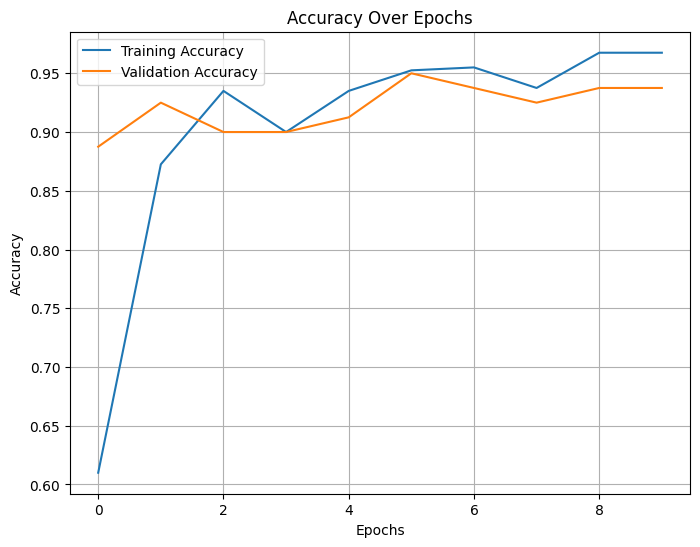

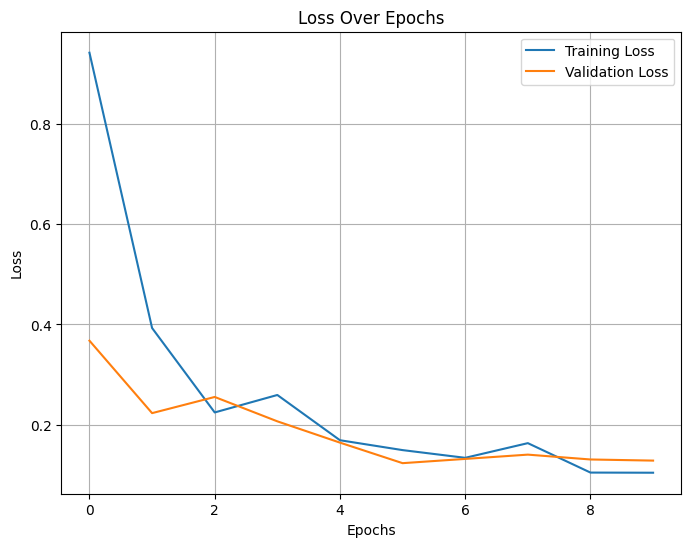

In [12]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [58]:
import os
import shutil

# Path to the directory to remove
test_dir = "/content/testData"

# Remove the directory and its contents
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    print(f"Directory {test_dir} and its contents have been removed.")
else:
    print(f"Directory {test_dir} does not exist.")


Directory /content/testData does not exist.


In [59]:
from google.colab import files
uploaded = files.upload()

In [61]:
# Unzipping the uploaded file
zip_path ='testData.zip'  # Replace with your file name

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/testData')


test_dir = '/content//testData/testData'  # Path to extracted folder

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score

# Create a data generator for test data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size= 32,
    class_mode='categorical',  # Use categorical to match training
    shuffle=False
)

# Make predictions
predictions = model.predict(test_generator)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the generator
true_classes = test_generator.classes

# Calculate accuracy
test_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 4 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
Test Accuracy: 100.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


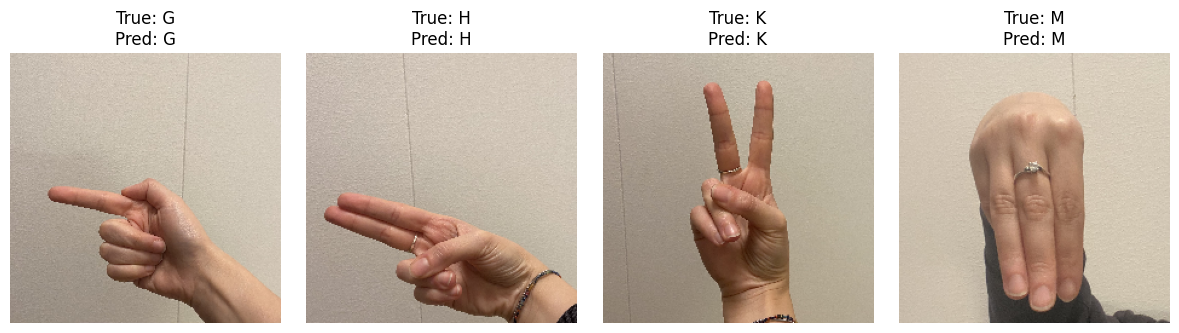

In [63]:
import matplotlib.pyplot as plt

# Map class indices to class labels
class_labels = list(test_generator.class_indices.keys())

# Fetch a batch of images and true labels
batch = next(test_generator)
images, true_labels_one_hot = batch

# Convert true labels from one-hot encoding to class indices
true_labels = np.argmax(true_labels_one_hot, axis=1)

# Predict labels for the batch
predictions_batch = model.predict(images)
predicted_labels = np.argmax(predictions_batch, axis=1)

# Plot the images with true and predicted labels
plt.figure(figsize=(12, 12))
for i in range(len(images)):  # Display up to 16 images
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    true_label = class_labels[true_labels[i]]
    predicted_label = class_labels[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
